# PyEO: How to train your classifier..

**Table of Contents**<a id='toc0_'></a>    
- [How to Delineate Sample Areas (in QGIS)](#toc1_)    
  - [Heiko's Instructional Video](#toc1_1_)    
  - [Matt's Instructional Video](#toc1_2_)    
    - [Written QGIS Tips](#toc1_2_1_)    
- [Setting up the Notebook](#toc2_)    
  - [Import the Required Libraries](#toc2_1_)    
  - [Specify the Root Directory](#toc2_2_)    
  - [Initialise the Logger](#toc2_3_)    
- [Single Tile Approach](#toc3_)    
  - [Extract Spectral Information from Sentinel-2 Imagery](#toc3_1_)    
    - [Create `out_folder` if it does not exist](#toc3_1_1_)    
    - [Run `extract_features_to_csv`](#toc3_1_2_)    
  - [Model Creation and Training](#toc3_2_)    
  - [Accuracy Statistics](#toc3_3_)    
  - [Imagery Classification](#toc3_4_)    
  - [Visualise the Classified Imagery](#toc3_5_)    
- [Multiple Tile and Training Shapefiles Approach](#toc4_)    
  - [Classify Directory](#toc4_1_)    
  - [Visualise the Classifications](#toc4_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In the previous notebook, we queried and downloaded Sentinel-2 imagery. Now, we need to create a model to classify the land cover (and thus detect changes in forest cover between two date periods).

To build a model, we will need training data. For PyEO, we define training data as pixel surface reflectance values and their corresponding land cover classes.

The section below details how to delineate training polygons in QGIS, but if you already have training data stored as a shape file, then you can skip and proceed to [importing the pyeo library](#Import-the-Required-Libraries).

# <a id='toc1_'></a>[How to Delineate Sample Areas using QGIS](#toc0_)

## <a id='toc1_1_'></a>[Heiko's Instructional Video](#toc0_)

The below recording is from Prof. Heiko Balzter. Here Heiko takes users through the process of creating shapefiles over Sentinel-2 imagery.

You may need to close the file manager tab to the left of this notebook, to see the embedded video more clearly.

In [19]:
# Heiko's training sample delineation over Rutland, UK.
from IPython.display import HTML

# Note: On the HPC, the below output is black (probably a firewall restriction)
# On sepal, the video plays.
HTML('<iframe width="1080" height="490" src="https://leicester.cloud.panopto.eu/Panopto/Pages/Viewer.aspx?id=a4568baf-c85d-4fab-b6c4-ac9300ed6ab2" frameborder="0" allowfullscreen></iframe>')

## <a id='toc1_2_'></a>[Matt's Instructional Video](#toc0_)

# TODO Matt to record a video delineating samples over Kenya covering these topics:
- How to create a shapefile for sampling  
- The advised structure of the shapefile e.g. id, class  
- Digitising toolbars  
- How to delineate  
- Sample away from class edges  
- Reshape often  
- Send2GE plugin to inspect high-res imagery for uncertain land cover classes  
- Save often  
- Sample underrepresented classes more  

### <a id='toc1_2_1_'></a>[QGIS Tips](#toc0_)

1. Whilst in QGIS, make sure you have the **Digitizing** and **Advanced Digitizing** toolbars enabled. To do so, click:  
    - View > Toolbars > Tick Digitizing and Advanced Digitizing

2. To delineate features, use the **Add Polygon Feature** tool. It looks like this: ![image](/data/clcr/shared/IMPRESS/matt/pyeo_1/pyeo_notebooks/Create_polygon.PNG) 

3. Avoid delineating near the edges of land cover, e.g. at the forest edge adjacent to a road. These edge pixels will capture the variation in land-cover at the sub-pixel level, confusing your classifier. 

3. The **Reshape Features** tool, is extremely useful for extending already delineated polygons. Click inside the polygon you want to extend, then click any points outside of the polygon (covering your land cover class of interest), once ready - click inside the polygon to complete the loop, and right click to finish delineation. The tool icon looks like this: ![image](/data/clcr/shared/IMPRESS/matt/pyeo_1/pyeo_notebooks/Reshape_features.PNG)

4. Install Google Earth Pro on your PC, https://www.google.com/earth/about/versions/ , which offers very-high resolution satellite imagery, and Google StreetView, to help you understand the land covers you are delineating.

5. Install the QGIS plugin, **Send2GE**. This plugin sends your location directly to your installed Google Earth Pro. To do so, click on the Send2GE icon, ![image](/data/clcr/shared/IMPRESS/matt/pyeo_1/pyeo_notebooks/Send2GE.PNG), and then click on the location you want to view in Google Earth Pro.

6. Consider your Land Cover Classes and tailor them to what you want your product to achieve.  
Below are a list of classes that we have used for our `pyeo` classifier, but alternative classes may be more appropriate for your needs. 

    1 = Primary Forest
    2. Plantation Forest
    3. Bare Soil
    4. Crops
    5. Grassland
    6. Open Water
    7. Burn Scar
    8. Cloud
    9. Cloud Shadow
    10. Haze
    11. Sparse Woodland
    12. Dense Woodland
    13. Artificial
    

# <a id='toc2_'></a>[Setting up requirements to use this Notebook](#toc0_)

## Select the pyeo_env conda environment
- Use the drop-down list at the top right of the Jupyter notebook window
- If pyeo_env is not available in the list please open PyEO_1_Setup.ipynb and follow the instructions to install it.

## <a id='toc2_1_'></a>[Import the Required Libraries](#toc0_)

Before proceeding, let's check that the import statements from pyeo execute correctly.

In [20]:
import os
from pyeo_1 import classification as cls
from pyeo_1 import filesystem_utilities as file_utils
import pandas as pd
print("library imports complete")

library imports complete


In [21]:
import os
os.environ["GDAL_DATA"] = "/home/sepal-user/miniconda3/envs/pyeo_env/share/gdal"
os.environ["PROJ_LIB"] = "/home/sepal-user/miniconda3/envs/pyeo_env/share/proj"


In [22]:
os.environ

environ{'SHELL': '/bin/bash',
        'SEPAL': 'true',
        'SUDO_GID': '0',
        'HOSTNAME': 'dfe71a63def4',
        'JAVA_HOME': '/usr/local/lib/sdkman/candidates/java/current',
        'SUDO_COMMAND': '/usr/bin/bash -c python3 /usr/local/bin/jupyter-notebook --no-browser --allow-root --ip=0.0.0.0 --port=8888 --NotebookApp.token= --NotebookApp.base_url=/api/sandbox/jupyter/ --NotebookApp.notebook_dir=/home/sepal-user --FileContentsManager.delete_to_trash=False --VoilaConfiguration.enable_nbextensions=True --VoilaConfiguration.show_tracebacks=True --ContentsManager.allow_hidden=True',
        'SUDO_USER': 'root',
        'PWD': '/home/sepal-user',
        'LOGNAME': 'sepal-user',
        'R_LIBS_SITE': '/usr/local/lib/R/site-library:/usr/lib/R/site-library:/usr/lib/R/library:/shiny/library',
        'HOME': '/home/sepal-user',
        'LANG': 'en_US.UTF-8',
        'R_LIBS_USER': '/home/sepal-user/.R/library',
        'TERM': 'xterm-color',
        'USER': 'sepal-user',
        

## <a id='toc2_2_'></a>[Specify the Root Directory](#toc0_)

This is the root directory that you want to store your data from. The notebook will use this as the prefix for your training raster and training shapefile filenames.

In [23]:
# pyeo_home = "/home/sepal-user/pyeo_home/pyeo_1"
pyeo_home = "/home/sepal-user/pyeo_1_test_installation_20230329_1/pyeo_1/"

## <a id='toc2_3_'></a>[Initialise the Logger](#toc0_)

When running `pyeo`, we record our processing efforts, parameters etc. in a log file (a .txt file). If we are ever curious about what `pyeo` has done and when, we can look at the log file.  
So below, we initialise our log file. Replace `log_path` with your own path.  
 **Note: the log.txt does not need to exist before running the function**

In [24]:
log_filename = "log.txt"
log = file_utils.init_log(os.path.join(pyeo_home , 'logs',  log_filename))

# Let's add some information to the log
log.info(f'PyEO_1_Model_Training Notebook Running')
log.info(f'- pyeo_home set to: {pyeo_home}')

2023-03-30 12:57:27,106: INFO: ****PROCESSING START****
2023-03-30 12:57:27,108: INFO: PyEO_1_Model_Training Notebook Running
2023-03-30 12:57:27,110: INFO: - pyeo_home set to: /home/sepal-user/pyeo_1_test_installation_20230329_1/pyeo_1/


Whenever a function writes to the log, the output will be displayed in the Python cell output, but the log file can also be viewed in a text editor.  
**Note, sometimes not all of the log file output in the cell outputs is displayed, so it is best to view the log.txt file in an external text editor.**   

# <a id='toc3_'></a>[Single Tile Approach](#toc0_)

In this section, we will follow the individual steps to extract spectral information from the Sentinel-2 imagery using our training shapefiles, train a Random Forest model on the spectral values of the land cover classes, and classify a Sentinel-2 image tile.

## <a id='toc3_1_'></a>[Extract Spectral Information from Sentinel-2 Imagery](#toc0_)

Since we have delineated our training polygons, we can now extract the spectral information from the imagery, by running `cls.extract_features_to_csv()` in the cell below.  
First, specify the paths to the training shapefile, training raster and the out directory.

In [25]:
# specify the path of the training shapefile
training_shape_filename = "models/composite_T36MYE_20230220T074941_clipped_features.shp"

# specify the path of the training raster
training_raster_filename = "models/composite_T36MYE_20230220T074941_clipped.tif"

# specify the output folder
out_folder = "models/output"

# specify the out filename for the csv
out_filename = "composite_T36MYE_20230220T074941_clipped.csv"

### <a id='toc3_1_1_'></a>[Create `out_folder` if it does not exist](#toc0_)

In [26]:
if not os.path.exists(os.path.join(pyeo_home, out_folder)):
    os.mkdir(os.path.join(pyeo_home, out_folder))

In [27]:
from osgeo import osr, gdal

raster_path = "/home/sepal-user/pyeo_1_test_installation_20230329_1/pyeo_1/models/composite_T36MYE_20230220T074941_clipped.tif"

raster = gdal.Open(raster_path)
projection = raster.GetProjection()

# create a spatial reference object from the WKT string
spatial_ref = osr.SpatialReference()
spatial_ref.ImportFromWkt(projection)

# print the projection information in a more human-readable format
print(spatial_ref.ExportToPrettyWkt())


PROJCS["Arc 1960 / UTM zone 37N",
    GEOGCS["Arc 1960",
        DATUM["Arc_1960",
            SPHEROID["Clarke 1880 (RGS)",6378249.145,293.465,
                AUTHORITY["EPSG","7012"]],
            TOWGS84[-160,-6,-302,0,0,0,0],
            AUTHORITY["EPSG","6210"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4210"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",39],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","21097"]]


In [28]:
from osgeo import ogr

# open the shapefile
shapefile = ogr.Open('/home/sepal-user/pyeo_1_test_installation_20230329_1/pyeo_1/models/composite_T36MYE_20230220T074941_clipped_features.shp')

# get the layer from the shapefile
layer = shapefile.GetLayer()

# get the spatial reference system from the layer
spatial_ref = layer.GetSpatialRef()

# print the projection information in Proj4 format
print(spatial_ref.ExportToPrettyWkt())


PROJCS["Arc 1960 / UTM zone 37N",
    GEOGCS["Arc 1960",
        DATUM["Arc_1960",
            SPHEROID["Clarke 1880 (RGS)",6378249.145,293.465,
                AUTHORITY["EPSG","7012"]],
            TOWGS84[-160,-6,-302,0,0,0,0],
            AUTHORITY["EPSG","6210"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4210"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",39],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","21097"]]


### <a id='toc3_1_2_'></a>[Run `extract_features_to_csv`](#toc0_)

Now, we can run the `cls.extract_features_to_csv` function.  
If the column heading of your training shapefile is not `CODE`, substitute the correct column name with the `attribute` argument.

In [29]:
# declare our path variables as easier to read variables
out_path = f"{os.path.join(pyeo_home, out_folder)}{os.sep}{out_filename}"
training_raster_path = os.path.join(pyeo_home, training_raster_filename)
training_shapefile_path = os.path.join(pyeo_home, training_shape_filename)

# run the function to extract the spectral values and assigned classes from the training raster and training shapefile
cls.extract_features_to_csv(in_ras_path=training_raster_path,
                            training_shape_path=training_shapefile_path,
                            out_path=out_path,
                            attribute="class")

2023-03-30 13:24:12,014: INFO: Get training data from /home/sepal-user/pyeo_1_test_installation_20230329_1/pyeo_1/models/composite_T36MYE_20230220T074941_clipped.tif
2023-03-30 13:24:12,017: INFO:                    and /home/sepal-user/pyeo_1_test_installation_20230329_1/pyeo_1/models/composite_T36MYE_20230220T074941_clipped_features.shp
2023-03-30 13:24:12,206: INFO: Shape raster path /home/sepal-user/pyeo_1_test_installation_20230329_1/pyeo_1/notebooks/tmpd1utvnw3/composite_T36MYE_20230220T074941_clipped_features_rasterised
2023-03-30 13:24:12,489: INFO: 4 bands in image file
2023-03-30 13:24:12,491: INFO: 11943 training pixels in shapefile


Let's see what `features.csv` looks like, by reading in the csv and printing the first 5 rows.  

Each row represents a pixel of a certain class. The first column in each row is the class of that pixel, with the columns after that being the Sentinel 2 blue, green, red and NIR value of that pixel.

In [30]:
# declare out_path from previous cell as csv_path, to avoid confusion
csv_path = out_path

# read in our spectral signatures
features = pd.read_csv(csv_path)

#TODO: No header flag

# prints the first 5 rows of features
features.head(5)

,2.0,182.0,316.0,195.0,2780.0
0,2.0,189.0,306.0,206.0,2906.0
1,2.0,190.0,295.0,204.0,2850.0
2,2.0,187.0,289.0,202.0,2773.0
3,2.0,170.0,297.0,202.0,2798.0
4,2.0,191.0,308.0,209.0,2873.0


In [ ]:
# Histogram to view class balance

## <a id='toc3_2_'></a>[Model Creation and Training](#toc0_)

You can create a scikit-learn Extra Trees Classifier using pyeo with the code in the cell below:

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import ensemble as ens
import numpy as np
import joblib

# TODO Use Pyeo_1 function to balance training data
#https://github.com/eogit/pyeo/blob/master/pyeo/apps/model_creation/create_rf_model_from_region.py
# https://github.com/eogit/pyeo/blob/b9f1563913515e53780a19e36cb104f1f2a7364a/pyeo/classification.py#L1111


# initialise an Extra Trees Classifier
model = ens.ExtraTreesClassifier(bootstrap=False, criterion="gini", max_features=0.55, min_samples_leaf=2,
                                    min_samples_split=16, n_estimators=100, n_jobs=-1, class_weight='balanced')

# load signatures from csv file
features, labels = cls.load_signatures(csv_path, sig_datatype=np.int32)

# split into test and train samples
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=.25, random_state=101)

# train the model
model.fit(X_train, y_train)

# TODO: Capture confusion matrix and accuracy from 25% of validation pixels of the pyeo forestmind 
## (already output to log file)
# TODO: 
## Example under heiko/matogrosso... mato_rf_toby_1_1.txt


# save the model

joblib.dump(model, filename = os.path.join(pyeo_home, out_folder, 'model.pkl'))


['/home/sepal-user/pyeo_1_test_installation_20230329_1/pyeo_1/models/output/model.pkl']

## <a id='toc3_3_'></a>[Accuracy Statistics](#toc0_)

Now that we have a model trained from shapefiles overlaid a Sentinel-2 image tile, we need to assess the model accuracy.  

To do that, we will use the model to predict the classes of `y_test` from the values of `X_test`.

In [32]:
# make a prediction
y_pred = model.predict(X_test)

# write classification labels
target_names = ["Primary Forest",
          "Plantation Forest",
          "Bare Soil",
          "Crops",
          "Grassland",
          # "Open Water",
          "Artificial"]

# create classification metrics report
report = classification_report(y_true=y_test, y_pred=y_pred, target_names=target_names)

# write classification report to file
with open(os.path.join(pyeo_home, out_folder, 'class_scores.txt'), "w") as txt:
    print(report, file=txt)

# view the report
print(report)

                   precision    recall  f1-score   support

   Primary Forest       1.00      0.98      0.99      1516
Plantation Forest       0.90      0.98      0.94       345
        Bare Soil       0.99      1.00      1.00       152
            Crops       1.00      1.00      1.00       344
        Grassland       1.00      1.00      1.00       458
       Artificial       1.00      0.99      0.99       171

         accuracy                           0.98      2986
        macro avg       0.98      0.99      0.99      2986
     weighted avg       0.99      0.98      0.98      2986



## <a id='toc3_4_'></a>[Imagery Classification](#toc0_)

If we are happy with the performance of the model, we can now classify a Sentinel-2 image tile, if we believe the values the model was trained on represent the spectral values of the land cover of the imagery of interest.  

In [33]:
cls.classify_image(image_path=training_raster_path,
                   model_path= os.path.join(pyeo_home, out_folder, 'model.pkl'),
                   class_out_path=os.path.join(pyeo_home, out_folder, 'composite_T36MYE_20211212T075229_class.tif'),
                   prob_out_path=None,
                   apply_mask=False,
                   out_format="GTiff",
                   chunks=10,
                   nodata=0,
                   skip_existing = False)

2023-03-30 13:26:45,418: INFO: Classifying file: /home/sepal-user/pyeo_1_test_installation_20230329_1/pyeo_1/models/composite_T36MYE_20230220T074941_clipped.tif
2023-03-30 13:26:45,423: INFO: Saved model     : /home/sepal-user/pyeo_1_test_installation_20230329_1/pyeo_1/models/output/model.pkl
2023-03-30 13:26:45,973: INFO: Proportion of non-missing values: 100.00%
2023-03-30 13:26:46,275: INFO:    Number of chunks 10 Chunk size 265194 Chunk residual 6
2023-03-30 13:26:46,276: INFO:    Classifying chunk 1 of size 265194
2023-03-30 13:26:48,512: INFO:    Classifying chunk 2 of size 265194
2023-03-30 13:26:50,391: INFO:    Classifying chunk 3 of size 265194
2023-03-30 13:26:52,282: INFO:    Classifying chunk 4 of size 265194
2023-03-30 13:26:54,296: INFO:    Classifying chunk 5 of size 265194
2023-03-30 13:26:56,267: INFO:    Classifying chunk 6 of size 265194
2023-03-30 13:26:58,321: INFO:    Classifying chunk 7 of size 265194
2023-03-30 13:27:00,364: INFO:    Classifying chunk 8 of size

'/home/sepal-user/pyeo_1_test_installation_20230329_1/pyeo_1/models/output/composite_T36MYE_20211212T075229_class.tif'

## <a id='toc3_5_'></a>[Visualise the Classified Imagery](#toc0_)

In [34]:
def visualise_classification(classified_path: str, labels: list):

    from osgeo import gdal
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors

    ds = gdal.Open(classified_path)
    array = np.array(ds.GetRasterBand(1).ReadAsArray())

    counts, _ = np.histogram(array, bins = len(labels))
    print(counts)
    percent = counts / counts.sum()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))


    def discrete_cmap(N, base_cmap=None):
        """Create an N-bin discrete colormap from the specified input map"""

        # this function was taken on 10/03/2023 from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
        # author: Jake Vanderplas

        base = plt.cm.get_cmap(base_cmap)
        color_list = base(np.linspace(0, 1, N))
        cmap_name = base.name + str(N)
        return base.from_list(cmap_name, color_list, N)

    cmap = discrete_cmap(len(labels), base_cmap="coolwarm")
    # cmap = discrete_cmap(len(labels), base_cmap="cubehelix")
    cmap.set_bad("red")
    colour_list = [mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)]

    x = np.arange(1, (len(labels) + 1))
    ax1.bar(x, percent, color=colour_list)
    # ax1.set_xticks(x, labels=labels, rotation=35, ha="right")
    ax1.set_title("Classes distribution")
    ax2.set_title("Classification raster displayed")

    ax2.imshow(array, cmap=cmap, aspect="auto")
    plt.show()

    return

[1537745  389158  607136       0       0  117907]


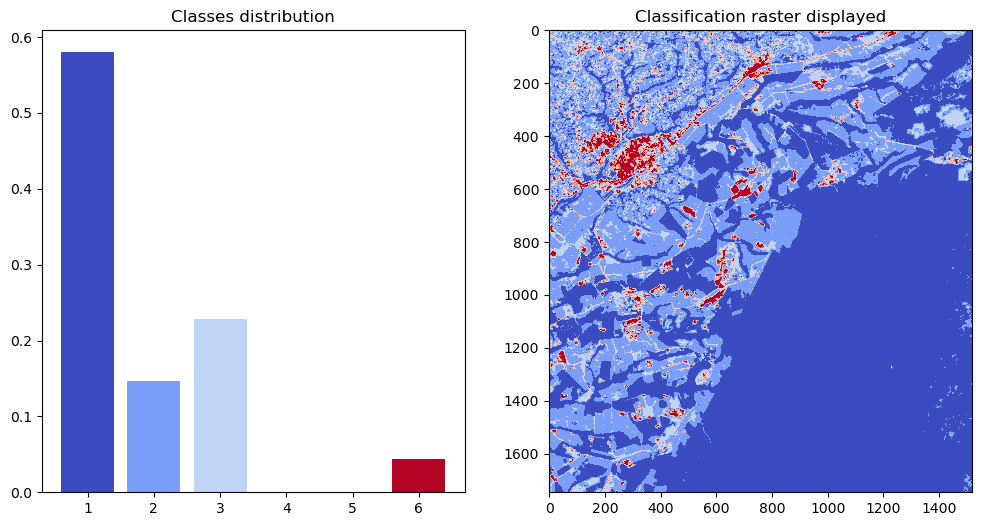

In [35]:
# specify the path of the classified image
classified_path = os.path.join(pyeo_home, out_folder, 'composite_T36MYE_20211212T075229_class.tif')

# create a list of class labels
labels = [
    "Primary Forest",
    "Plantation Forest",
    "Bare Soil",
    "Crops",
    # "Open Water",
    "Grassland",
    "Artificial"
    ]

visualise_classification(classified_path=classified_path, labels=labels)

In [ ]:
#TODO: Use class balancing

# <a id='toc4_'></a>[Multiple Tile and Training Shapefiles Approach](#toc0_)

We can also train a Random Forest classifier on multiple Sentinel-2 tiles with multiple training shapefiles. This approach can create a superior classifier because the training shapefiles can cover more tiles, providing the model with a variety of spectral values per class.  

The `create_rf_model_for_region` function assumes the training rasters and training shapefiles are structured like the cell diagram below.   
**Note, the filenames do not need to be a specific format**

In [ ]:
# model_folder
    # training_raster_tile_1
    # training_shapefile_tile_1
    # training_raster_tile_2
    # training_shapefile_tile_2

In [13]:
# specify the path to the directory structure
out_folder = "/data/clcr/shared/IMPRESS/matt/pyeo_1/pyeo_notebooks/resources/models/model_2/"

# name the model that will be created
model_file = "model_simple.pkl"

cls.create_rf_model_for_region(path_to_region=out_folder,
                               model_out=f"{out_folder}{model_file}",
                               attribute="class"
                               #,attribute="CODE" # replace this line with the one above, if training shapefile has CODE as class heading
                               )

2023-03-14 12:54:32,653: INFO: Create a random forest classification model for region based on tif/shp file pairs: /data/clcr/shared/IMPRESS/matt/pyeo_1/pyeo_notebooks/resources/models/model_2/
2023-03-14 12:54:32,660: INFO: Collecting training data from all tif/shp file pairs.
2023-03-14 12:54:32,661: INFO: Analysing shapefile: /data/clcr/shared/IMPRESS/matt/pyeo_1/pyeo_notebooks/resources/models/model_2/composite_T36MYE_20191128T075251.shp
2023-03-14 12:54:33,016: INFO: EPSG codes of the image and shapefile: 21097, 21097
2023-03-14 12:54:34,374: INFO: This training data shapefile includes 7 classes: [1, 2, 3, 4, 5, 6, 13]
2023-03-14 12:54:34,375: INFO: 4 bands in image file
2023-03-14 12:54:34,376: INFO: (4, 11004, 11004)
2023-03-14 12:54:34,376: INFO: (11004, 11004)
2023-03-14 12:54:34,377: INFO: 
[0 0 0 ... 0 0 0]
2023-03-14 12:54:34,378: INFO: 
[0 0 0 ... 0 0 0]
2023-03-14 12:54:34,379: INFO: 
[0 0 0 ... 0 0 0]
2023-03-14 12:54:39,570: INFO: (4, 1000958)
2023-03-14 12:54:39,572: I

In [14]:
# view classification report metrics
with open(f"{out_folder}class_scores.txt", "r") as report:
    print(report.read())

              precision    recall  f1-score   support

           1       0.94      0.94      0.94     12519
           2       0.95      0.92      0.93      1680
           3       0.99      0.99      0.99     12626
           4       0.96      0.91      0.93      1303
           5       0.86      0.89      0.87      4730
           6       0.99      0.99      0.99     12555
          11       0.97      0.99      0.98      6178
          13       0.98      0.96      0.97     11020

    accuracy                           0.96     62611
   macro avg       0.95      0.95      0.95     62611
weighted avg       0.96      0.96      0.96     62611




As of yet, we have not written a function for `pyeo` to take user-supplied class names, which would enable class names to be displayed in the classification metrics report above.  

Therefore, currently users should substitute their own class names to pass to the classification report function.

## <a id='toc4_1_'></a>[Classify Directory](#toc0_)

`cls.classify_directory` requires the `class_out_dir` to already exist, so make sure that this directory is present before running the function.

In [16]:
# provide the path of the directory of images to classify
image_directory = "/data/clcr/shared/IMPRESS/matt/pyeo_1/pyeo_notebooks/resources/data/to_classify"

# specify the path of the model created in the cell above
model_path = f"{out_folder}{model_file}"

# provide the path of the classified output folder
class_out_dir = "/data/clcr/shared/IMPRESS/matt/pyeo_1/pyeo_notebooks/resources/data/classified"

# run the function to classify the directory of images you provided
cls.classify_directory(in_dir=image_directory,
                       model_path=model_path,
                       class_out_dir=class_out_dir,
                       chunks=10)

2023-03-14 11:14:49,534: INFO: Classifying files in /data/clcr/shared/IMPRESS/matt/pyeo_1/pyeo_notebooks/resources/data/to_classify
2023-03-14 11:14:49,535: INFO: Class files saved in /data/clcr/shared/IMPRESS/matt/pyeo_1/pyeo_notebooks/resources/data/classified
2023-03-14 11:14:49,536: INFO: Classifying file: /data/clcr/shared/IMPRESS/matt/pyeo_1/pyeo_notebooks/resources/data/to_classify/composite_T36MYE_20191128T075251.tif
2023-03-14 11:14:49,536: INFO: Saved model     : /data/clcr/shared/IMPRESS/matt/pyeo_1/pyeo_notebooks/resources/models/model_2/model_simple.pkl
2023-03-14 11:15:06,779: INFO: Proportion of non-missing values: 99.76%
2023-03-14 11:15:14,687: INFO:    Number of chunks 10 Chunk size 12079353 Chunk residual 6
2023-03-14 11:15:14,704: INFO:    Classifying chunk 1 of size 12079353
2023-03-14 11:19:38,941: INFO:    Classifying chunk 2 of size 12079353
2023-03-14 11:24:10,143: INFO:    Classifying chunk 3 of size 12079353
2023-03-14 11:28:37,642: INFO:    Classifying chunk

## <a id='toc4_2_'></a>[Visualise the Classifications](#toc0_)

Here, we can visualise the images we have just classified. Just pass the filename of the classified image.

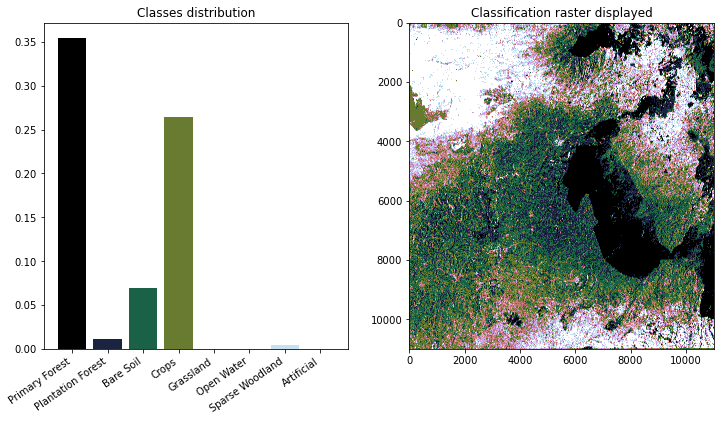

In [21]:
# specify the directory of a classified image
classified_path = f"{class_out_dir}/composite_T36MYE_20191128T075251_class.tif"

# create a list of class labels. In this example we have more classes because the additional classes were delineated to train this region rf model.
labels = [
    "Primary Forest",
    "Plantation Forest",
    "Bare Soil",
    "Crops",
    "Grassland",
    "Open Water",
    "Sparse Woodland",
    "Artificial"
]

visualise_classification(classified_path=classified_path, labels=labels)

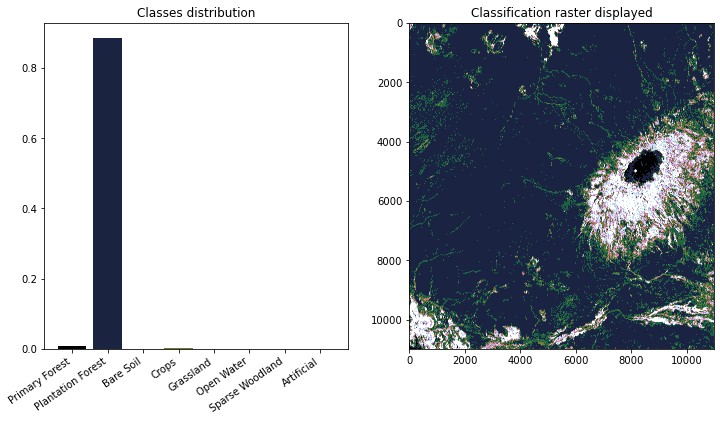

In [22]:
# specify the directory of a classified image
classified_path = f"{class_out_dir}/composite_T37NCC_20191120T074119_class.tif"

visualise_classification(classified_path=classified_path, labels=labels)

# note - this isn't a great rf model, I trained it quickly with few samples over this tile. This is intended as a toy model.